# Processing data
Purpose of this workbook is, given a super folder (which holds .csv files of interest), go through and allow filtering based on tag (using regex)

Then, can take specific subsets of this data to then plot together and allow comparison.

In [7]:
# Import Cell
import sys
sys.path.append('..')
from Utility import process_data_utils as pdu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os

In [8]:
# Define which super folder set you want (DEFAULT: "../Results")
super_folder = "../Results"

# Interpretation
path_total = glob.glob(os.path.join(super_folder,'*'))
path_list = [p for p in path_total if 
                    "L-" in p and # Maybe don't use this since RC doesn't always have it?
                    "Images" not in p and
                    "img" not in p and
                    ~os.path.isdir(p)]

df_master = pdu.create_formatted_df(path_list)


In [9]:
# Define which parameters you want to set as constant
# Leave out lines you want varied by commenting

sub_df = df_master[
        (df_master.linker == 4) &
    #    (df_master.concentration == 2.5) &
        (~df_master.mixing) &
        (~df_master.oven) &
        (df_master.edge == "darkbright")
        ]
exp_list = np.unique(sub_df.file)
num_exp = len(exp_list)
cm_arr = cm.get_cmap('viridis',num_exp)
print(exp_list)


['L-4_nM-10_mixing-F_oven-F_embed-Ag_edge-darkbright_thresh-ensemble.csv'
 'L-4_nM-2.5_mixing-F_oven-F_embed-Ag_edge-darkbright_thresh-ensemble.csv'
 'L-4_nM-5_mixing-F_oven-F_embed-Ag_edge-darkbright_thresh-ensemble.csv']


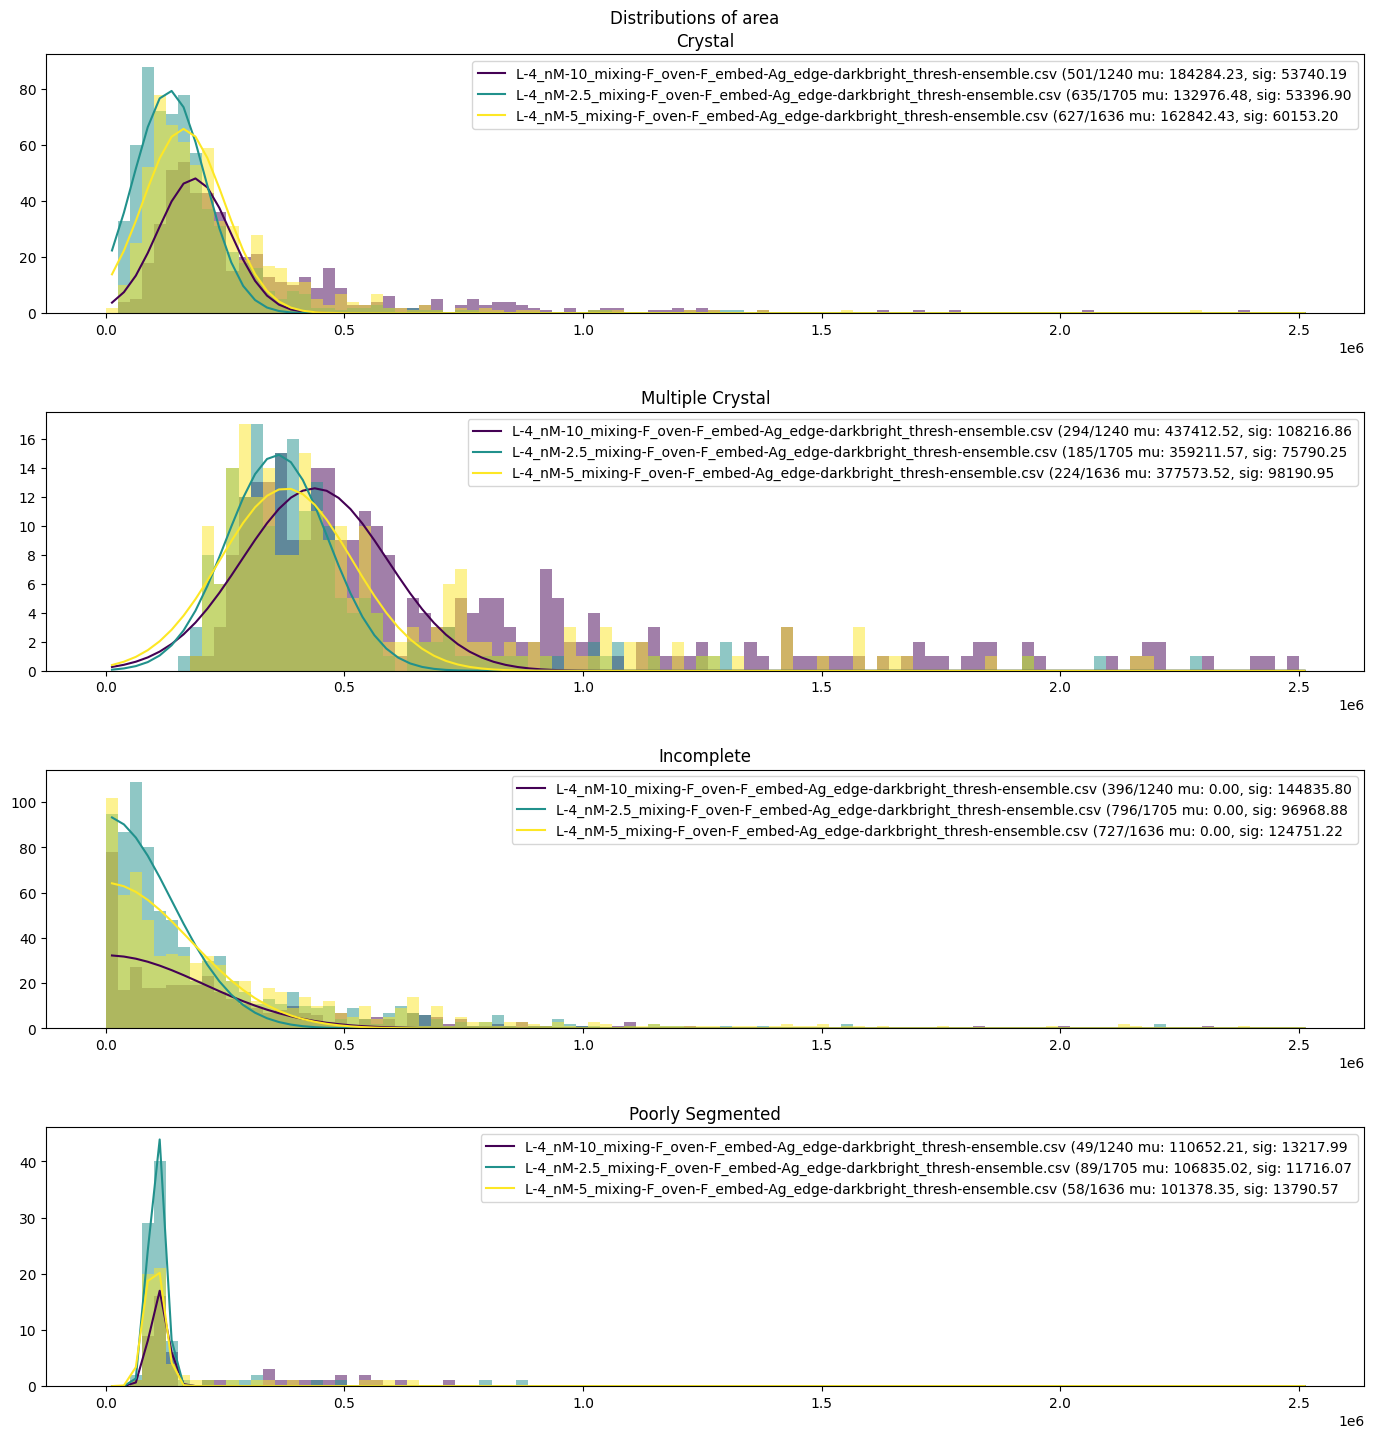

In [10]:
# Gaussian Cell
fig_gaussian = pdu.plot_feature_with_experiments_gaussian('area',exp_list,color_list=cm_arr.colors)
plt.show(fig_gaussian)



[6.6236556  0.72777652 0.5       ]
[0, 0, 0, 2, 2, 1, 4, 6, 12, 16, 16, 27, 22, 27, 28, 25, 18, 23, 21, 22, 14, 6, 9, 10, 8, 10, 11, 7, 8, 4, 7, 5, 4, 6, 6, 7, 3, 8, 8, 8, 2, 0, 3, 1, 2, 1, 3, 2, 4, 1, 1, 1, 1, 1, 2, 1, 4, 0, 0, 0, 2, 4, 2, 1, 2, 1, 3, 2, 1, 1, 3, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 1.0

[2.79258505 0.72993447 0.5       ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 5, 2, 7, 3, 7, 9, 3, 9, 8, 8, 5, 3, 4, 6, 4, 7, 12, 4, 7, 3, 3, 3, 9, 4, 3, 8, 3, 5, 0, 1, 3, 1, 2, 3, 1, 1, 4, 0, 2, 2, 3, 2, 3, 1, 2, 4, 1, 1, 2, 1, 0, 2, 1, 4, 3, 2, 2, 1, 1, 1, 2, 3, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 

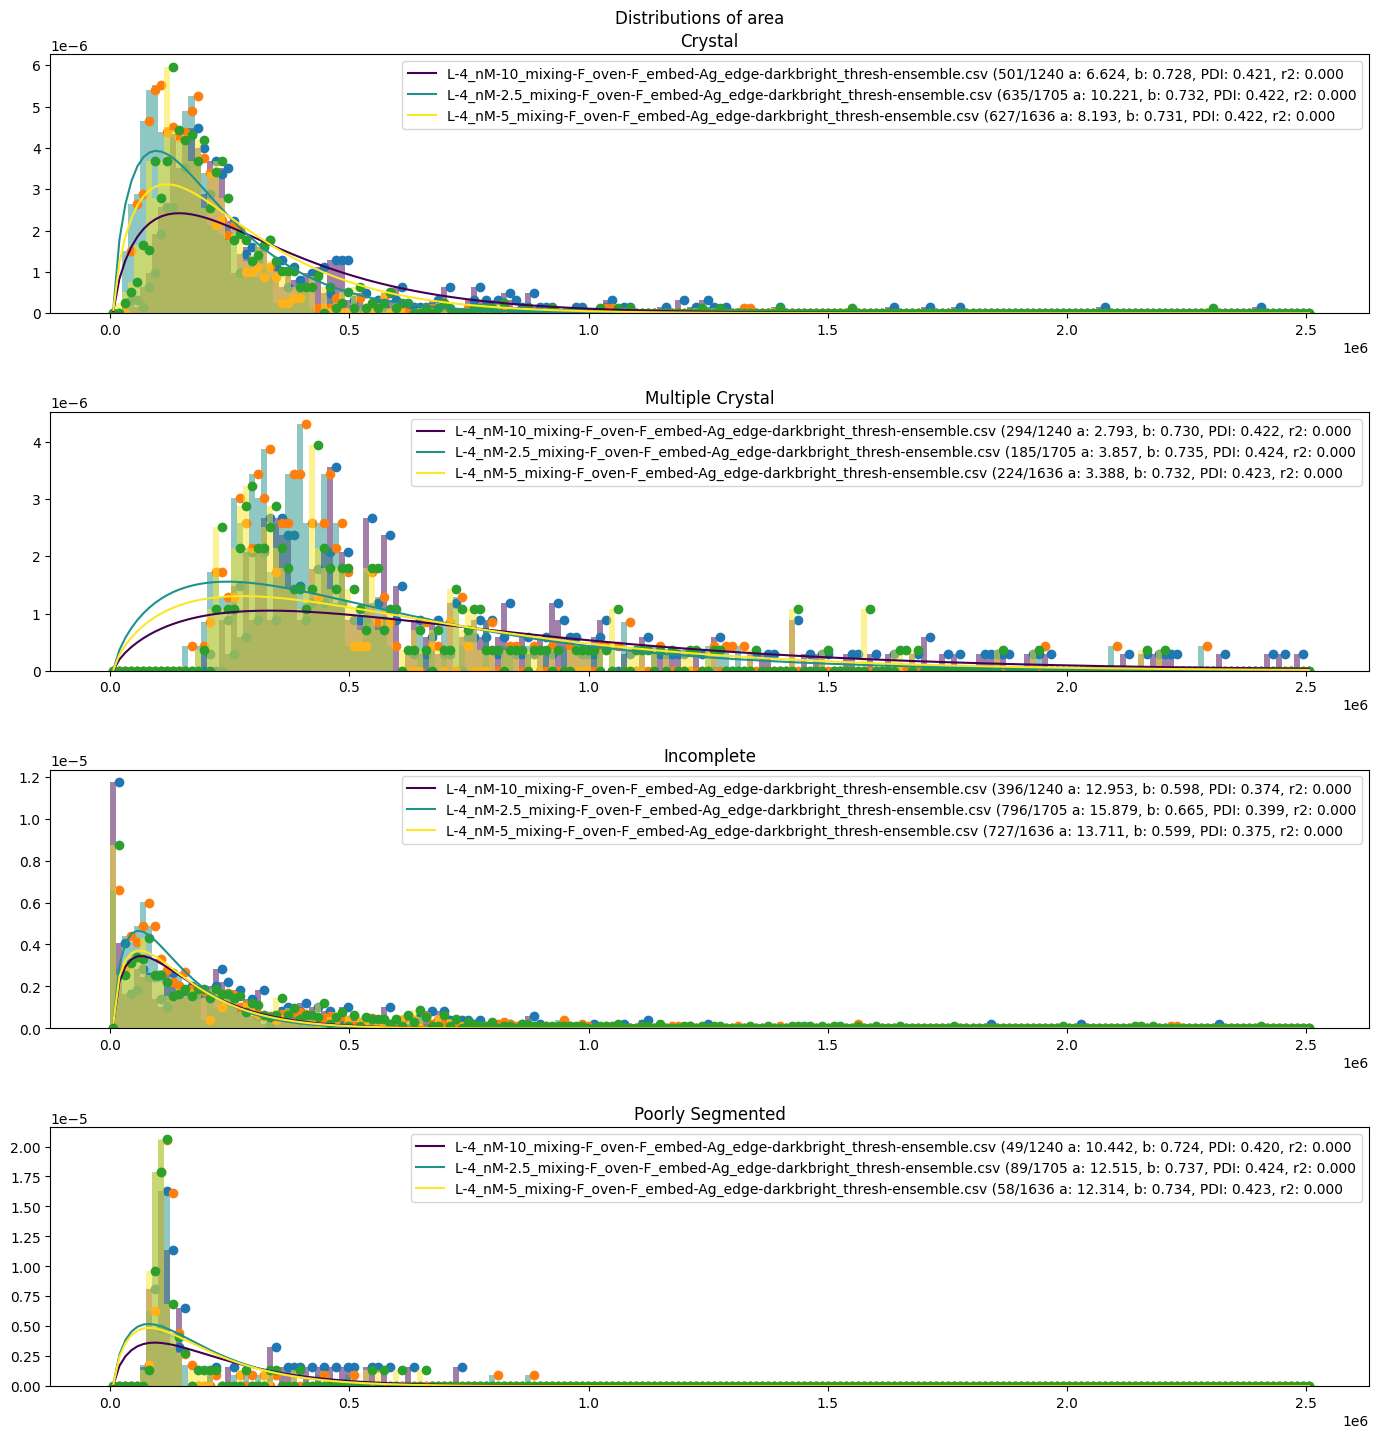

In [11]:
# Schulz Cell
fig_sz = pdu.plot_feature_with_experiments_schultz_zimm('area',exp_list,color_list=cm_arr.colors)
plt.show(fig_sz)



TypeError: schultz_zimm() takes 4 positional arguments but 5 were given

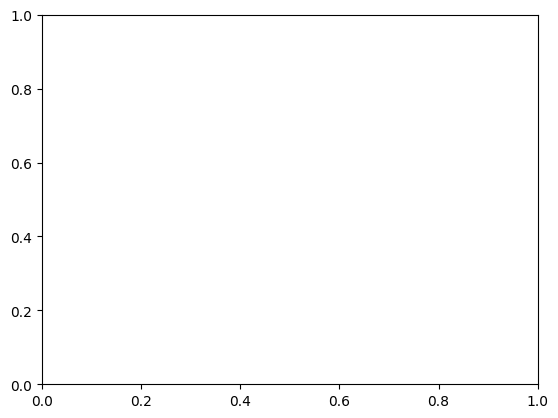

In [12]:
## WIP cell for checking out what's going on with Schultz-Zimm
from scipy.optimize import curve_fit
sz = pdu.schultz_zimm
df_oi = pdu.load_dataframe(exp_list[0])
df_oi = df_oi[df_oi["Labels"] == "Crystal"]
fig_oi, ax_oi = plt.subplots()
# COPY PASTING CODE FROM pdu
feature = 'area'
max_out = 2.50*10**6 if feature == 'area' else 2000


histogram_min = df_oi[feature].min()
histogram_max = df_oi[feature].max()
histogram_bins = np.round(np.linspace(histogram_min, max_out,200))


freq = pdu.get_frequency(df_oi,histogram_bins,feature)
scale_factor = 1#counts*histogram_bins[0]
x_bins = histogram_bins #+ (histogram_bins[2]-histogram_bins[1])/2 # Fit to center of bin
prob = np.array(freq)/(np.sum(freq))
popt,pcov = curve_fit(sz,x_bins,prob,
                                  p0=[0,0,1],
                                  bounds=([0.0,0.0,0.5],[50,5,2.1]),
                                  )
a = popt[0]
b = popt[1]
molecular_weight = b/a
molecular_number = (b+1)/a
pdi = molecular_weight/molecular_number


ax_oi.plot(x_bins,sz(histogram_bins,*popt)*scale_factor/np.diff(histogram_bins)[0],color='r')

weights=df_oi[feature]/len(df_oi[feature])
ax_oi.hist(x=df_oi[feature],bins=histogram_bins,color='r',alpha=.5,density=True)
ax_oi.scatter(histogram_bins,prob/np.diff(histogram_bins)[0])

ax_oi.legend()


print(popt)
ax_oi.plot(x_bins,sz(histogram_bins,
                     *[7,.75,.5,1e4])*scale_factor/np.diff(histogram_bins)[0],
                     color='g')


In [ ]:
c1 = 

SyntaxError: invalid syntax (4246105365.py, line 1)